<a href="https://colab.research.google.com/github/s-c-soma/Deeplearning-CMPE-258/blob/main/Assignment_3/Assignment_3_Part_B_2_Pytorch(with_auto_differentiation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3 Layer Neural Network (with relu nonlinearity) Using Pytorch(withauto differentiation)

# Implementation Details and Discussion

* Here, I have generated the 3d input and 2d output data first.
* Then I have built a 3 layer neural network with ReLU non linearity using Pytorch Auto Differenciation
* Here the output has 2 neurons

## Steps: 
I have listed down the the formula and steps I have followed in each section:
- Initialized the parameters for a three-layer network 
- Used Pytorch Auto Differentiation
- Defined the 3layer architechture 
- Then training including back propagation
- Finally updated the parameters.
- Validation is also done
- After 2000 epochs, loss is 0.3762931823730469

## Equation of Multi Layer:
$$ Z^{[l]} = W^{[l]}A^{[l-1]} + b^{[l]} $$

$$ A^{[l]} = g^{[l]}(Z^{[l]}) $$

Where $l$ is the `lth` layer.

## ExtraCredit:
* At the bottom I have plotted the data in 3d space. 
* To plot 3 dimensional data, I have reduced x into 2-d using TSNE

# Check if GPU/TPU available

In [4]:
!nvidia-smi

Mon Mar 22 00:23:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Colab environment

In [5]:
!python --version

Python 3.7.10


In [6]:
!pip list | grep tensor

tensorboard                   2.4.1         
tensorboard-plugin-wit        1.8.0         
tensorflow                    2.4.1         
tensorflow-datasets           4.0.1         
tensorflow-estimator          2.4.0         
tensorflow-gcs-config         2.4.0         
tensorflow-hub                0.11.0        
tensorflow-metadata           0.28.0        
tensorflow-probability        0.12.1        


In [7]:
!pip list | grep torch

torch                         1.8.0+cu101   
torchsummary                  1.5.1         
torchtext                     0.9.0         
torchvision                   0.9.0+cu101   


# Library

In [8]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from typing import Callable
from sklearn.manifold import TSNE
import pdb

# Generating Data: 3D Input :: 2D Output

In [9]:
# Make non-linear data, using 3 dimensional input data and 2 output neurons

n = 200
d = 3
x = np.random.uniform(-1, 1, (n, d))

weights_true = np.array([[5, 1, 4],[2, 1, 2]]).T
bias_true = np.array([0.5, 0.25])

# f(x) =  y = 5x + b
# f(x) = y = x^2w + b 

# y = w_0 * x_0 + w_1 * x_1 + w_2 * x_2 + b
y_true = (x ** 2) @ weights_true + x @ weights_true + bias_true
print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y_true.shape}')

def plot_3d(x, y, y_pred=None):
  import matplotlib.pyplot as plt
  from mpl_toolkits.mplot3d import Axes3D
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(x[:, 0], x[:, 1], x[:, 2], y_true, label='underlying function')
  if y_true is not None:
    ax.scatter(x[:, 0], x[:, 1], x[:, 2], y_true, label='our function')
  plt.legend()

#plot_3d(x, y_true, y_pred)

x: (200, 3), weights: (3, 2), bias: (2,), y: (200, 2)


In [10]:
# Generating data of 3 dim input and 2 dim output
n, d = 500, 3
x = torch.FloatTensor(n, d).uniform_(-1, 1)
weights_true = torch.tensor([[5,1,5],[1,2,1]]).float()
weights_true = torch.transpose(weights_true,0,1)
bias_true = torch.tensor([1,2])
#using torch
y_true = torch.mm(x**2,weights_true) + torch.mm(x,weights_true) + bias_true
print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y_true.shape}')

x: torch.Size([500, 3]), weights: torch.Size([3, 2]), bias: torch.Size([2]), y: torch.Size([500, 2])


# Building Multi Layer NN using auto differentiation: 3 Layer


In [11]:
class Linear(nn.Module):
  def __init__(self, input_dim, num_hidden):
    super(Linear, self).__init__()
    self.init = torch.rand(input_dim, num_hidden).float()
    self.weights = torch.nn.Parameter(self.init, requires_grad=True)
    self.bias = torch.zeros(num_hidden,)
  
  def __call__(self, x):
    self.x = x
    return torch.mm(x, self.weights) + self.bias

In [12]:
# Custom Model using nn.Linear modules
class TorchModel(nn.Module):
  def __init__(self, input_dim, num_hidden):
    super(TorchModel, self).__init__()
    self.linear1 = Linear(input_dim, num_hidden)
    self.relu1 = nn.ReLU()
    self.linear2 = Linear(num_hidden, 12)
    self.relu2 = nn.ReLU()
    self.linear3 = Linear(12, 2)
  
  def forward(self, x):
    l1 = self.linear1(x)
    r1 = self.relu1(l1)
    l2 = self.linear2(r1)
    r2 = self.relu2(l2)
    l3 = self.linear3(r2)
    return l3

# Model Training and Validation 

In [13]:
# Training
def torch_fit(x, y, model: Callable, loss: Callable, lr: float, num_epochs: int):
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)
  for epoch in range(num_epochs):
    optimizer.zero_grad() # Initialize gradient as zero
    y_pred_tensor = model(x) # Forward Pass
    loss_value = loss(y_pred_tensor, y) # Compute loss with MSE
    if epoch % 20 == 0:
      print(f'Epoch {epoch}, loss {loss_value}')
    loss_value.backward() # Use autogradient to compute backward pass
    optimizer.step() # Update weights 
  #plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left");
    
loss = nn.MSELoss()
model = TorchModel(d, 20)
y_pred = model(x)
torch_fit(x, y_true, model=model, loss=loss, lr=0.0035, num_epochs=2000)

Epoch 0, loss 387.5994567871094
Epoch 20, loss 4.397385597229004
Epoch 40, loss 3.683845281600952
Epoch 60, loss 3.10111141204834
Epoch 80, loss 2.638911485671997
Epoch 100, loss 2.2675371170043945
Epoch 120, loss 1.967488408088684
Epoch 140, loss 1.7235430479049683
Epoch 160, loss 1.5249284505844116
Epoch 180, loss 1.3626530170440674
Epoch 200, loss 1.2295911312103271
Epoch 220, loss 1.1196677684783936
Epoch 240, loss 1.0284614562988281
Epoch 260, loss 0.952519416809082
Epoch 280, loss 0.8888399600982666
Epoch 300, loss 0.8349670171737671
Epoch 320, loss 0.7886698842048645
Epoch 340, loss 0.7486255764961243
Epoch 360, loss 0.7138656973838806
Epoch 380, loss 0.6833595633506775
Epoch 400, loss 0.6564638614654541
Epoch 420, loss 0.6325733065605164
Epoch 440, loss 0.6113290786743164
Epoch 460, loss 0.5923241972923279
Epoch 480, loss 0.5753503441810608
Epoch 500, loss 0.5601329803466797
Epoch 520, loss 0.5464627742767334
Epoch 540, loss 0.5341340899467468
Epoch 560, loss 0.523009717464447


# Visualization: Training Data and Prediction

## Plot:: Comparison True vs Predicted Value

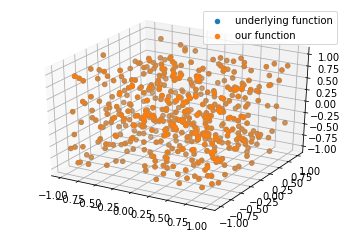

In [14]:
plot_3d(x, y_true, y_pred)

Text(0.5, 1.0, 'Plot:: Comparison True vs Predicted Value')

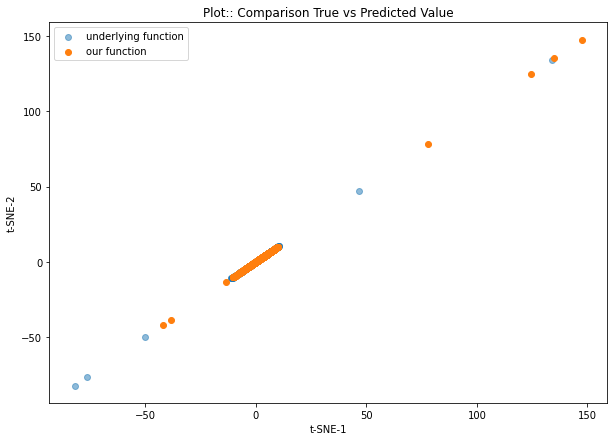

In [15]:
import numpy as np
from sklearn.manifold import TSNE

view = TSNE(n_components=3, perplexity=10,learning_rate=200,random_state=123).fit_transform(x, y_pred)

def plot_tsne(x, y_true, y_pred):
  plt.figure(figsize=(10,7))
  plt.scatter(view[:,0], view[:,0], alpha=0.5, label='underlying function')
  if y_true is not None:
    plt.scatter(view[:, 1], view[:, 1], label='our function')
  plt.xlabel('t-SNE-1')
  plt.ylabel('t-SNE-2')
  # plt.plot(x, y_true[:,0], y_true[:,0], color='blue', alpha=0.5, label='True Value')
  plt.legend()

plot_tsne(x, y_true, y_pred)
plt.title("Plot:: Comparison True vs Predicted Value")

## ExtraCredit: t-SNE 3D Plot

In [16]:
def plot_intereactive_3d(x, y, y_pred=None):
  import plotly.graph_objects as go

  fig = go.Figure()
  fig.add_trace(go.Scatter3d(x = x[:,0],
                    y = x[:,1],
                    z = y.reshape([-1]),
                    opacity=0.5, mode='markers', name='Underlying Function'
                    ))
 
  if y_pred is not None:
    fig.add_trace(go.Scatter3d(x = x[:,0],
                   y = x[:,1],
                   z = y_pred.reshape([-1]),
                   opacity=0.5, mode='markers', name='Predicted Function'
                  ))
    
  fig.update_layout(scene = dict(
                    xaxis_title='X1',
                    yaxis_title='X2',
                    zaxis_title='Y'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))
  fig.show()

In [17]:

X_reduced = TSNE(n_components=2).fit_transform(x)
y_true_reduced = TSNE(n_components=1).fit_transform(y_true)
y_pred_reduced = TSNE(n_components=1).fit_transform(model(x).detach())
print(f'X_reduced: {X_reduced.shape}, y_true_reduced: {y_true_reduced.shape}, y_pred_reduced: {y_pred_reduced.shape}')

plot_intereactive_3d(X_reduced,y_true_reduced,y_pred_reduced)

X_reduced: (500, 2), y_true_reduced: (500, 1), y_pred_reduced: (500, 1)


https://colab.research.google.com/drive/1HS3qbHArkqFlImT2KnF5pcMCz7ueHNvY?usp=sharing&authuser=1#scrollTo=cqENhTMpdlJT